# UTD19
Data source: UTD19 (utd19.ethz.ch)

https://www.nature.com/articles/s41598-019-51539-5

By downloading the UTD19 dataset, I have acknowledged that
- the data will be used only for academic and/or non-commercial purposes;
- for any publication that utilizes the UTD19 dataset, authors should include a reference to https://doi.org/10.1038/s41598-019-51539-5;
- that you are going to include the data source as UTD19 (utd19.ethz.ch) in the acknowledgment section of your publication.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geo_utils
from codetiming import Timer

import matplotlib.pyplot as plt

In [20]:
from bokeh.io import output_notebook, output_file, show
output_notebook()
from bokeh.io import export_png, export_svgs
from bokeh.plotting import figure
from bokeh.tile_providers import OSM, CARTODBPOSITRON, get_provider
from bokeh.models import ColumnDataSource, HoverTool, PrintfTickFormatter
from bokeh.models import CustomJS, Slider
from bokeh.util.hex import hexbin
from bokeh.layouts import gridplot, row


from bokeh.transform import factor_cmap, linear_cmap, log_cmap
from bokeh.palettes import turbo as operator_palette
from bokeh.palettes import RdYlGn 
from bokeh.palettes import turbo
from bokeh.palettes import Viridis256, Spectral5, Spectral10
from bokeh.palettes import cividis, viridis, magma, inferno
hist_palette = cividis(256)


Loading BokehJS ...

In [3]:
#geo_utils.query_dataset("2000-01-01", "2021-01-01", 'torino', output_name='torino_all.csv', input_name='UTD19.csv')

In [4]:
df_detector = pd.read_csv('detectors_public.csv').rename(columns={'citycode': 'city'}).set_index(['detid', 'city'])


In [5]:
df_to = pd.read_csv('torino_all.csv', dtype={'detid': 'string'})#.set_index(['detid', 'city'])
df_to = df_to.join(df_detector, on=['detid', 'city'])

df_to = geo_utils.wgs84_to_webmercator(df_to, lat='lat', lon='long', web_x='x', web_y='y') 

df_to = df_to.assign(
    timestamp=lambda x: pd.to_datetime(pd.to_datetime(x.day) + pd.to_timedelta(x.interval, unit='s'))
)
df_to = df_to.assign(
    time_millis=pd.to_datetime(df_to.timestamp).astype(int),
    business_day=lambda x: np.is_busday(x.timestamp.dt.date)
)


lon_limits = [df_to['long'].min(), df_to['long'].max()]
lat_limits = [df_to['lat'].min(), df_to['lat'].max()]
print('Date range: ', df_to['timestamp'].min(), ' - ', df_to['timestamp'].max())

Date range:  2016-09-26 00:00:00  -  2016-10-16 23:55:00


In [6]:
date_1 = '2016-09-26'
date_2 = '2016-09-27'
df_to_ranged = df_to.loc[df_to.timestamp > pd.to_datetime(date_1)].loc[df_to.timestamp < pd.to_datetime(date_2)]
print(len(df_to_ranged))

99743


In [7]:
df_to['flow'].min(), df_to['flow'].max()

(0.0, 19800.0)

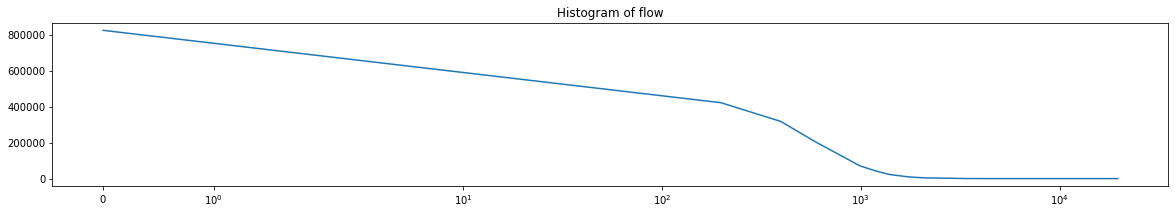

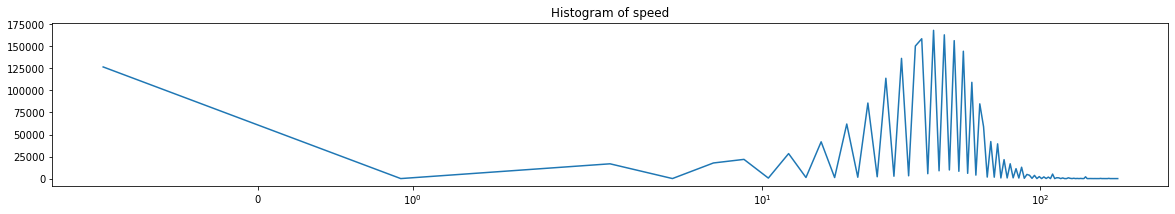

In [26]:
# explore dataset values

h, b = np.histogram(df_to.flow.values, bins=100)
plt.figure(figsize=(20,3))
plt.title('Histogram of flow')
plt.plot(b[:-1], h)
plt.xscale('symlog')
plt.show()

h, b = np.histogram(df_to.speed.values, bins=100)
plt.figure(figsize=(20,3))
plt.title('Histogram of speed')
plt.plot(b[:-1], h)
plt.xscale('symlog')
plt.show()

In [28]:
# Plot detected traffic flow at different hours for working week / weekend

hour_slices = [(0, 5, 'Night'), (5, 11, 'Morning'), (11, 15, 'Midday'), (15, 20, 'Afternoon'), (20, 24, 'Evening')]

p = [[geo_utils.get_tiled_figure(title='Business days, '+hs[2].lower(), lon_limits=lon_limits, lat_limits=lat_limits, hover=None), 
      geo_utils.get_tiled_figure(title='Weekend, '+hs[2].lower(), lon_limits=lon_limits, lat_limits=lat_limits, hover=None)]
    for hs in hour_slices]

flow_min = 100
flow_max = 2500
#fill_cmap = linear_cmap('speed', RdYlGn[11], low=100, high=1000)

for i, hs in enumerate(hour_slices):    
    df_selection = df_to.loc[df_to.timestamp.dt.hour > hs[0]].loc[df_to.timestamp.dt.hour < hs[1]]
    for j, is_busd in enumerate([True, False]): # working days
        p[i][j].x_range = p[0][0].x_range # link panning
        p[i][j].y_range = p[0][0].y_range # link panning
        p[i][j].background_fill_color = None 
        p[i][j].border_fill_color = None
        
        df_selection_busd = df_selection.loc[df_selection.business_day == is_busd]#.loc[df_selection.detid =='230']
        df_mean = df_selection_busd.groupby('detid').mean()
        source = ColumnDataSource(df_mean)
        source.data['alpha'] = source.data['flow']/flow_max

        p[i][j].circle(x="x", y="y", size=15, fill_color='red', fill_alpha='alpha', line_color=None, source=source)

output_file('public/img/torino_daytime_flow.html')        
        
show(gridplot(p))
                                    